In [2]:
import numpy as np

np.random.seed(0)

from typing import Tuple

import matplotlib.pyplot as plt

In [3]:
def generate_dataset(
    slope: float,
    intercept: float,
    noise_std_dev: float,
    n_samples: np.ndarray,
    lower_bound: float,
    upper_bound: float,
) -> Tuple[np.ndarray, np.ndarray]:

    X = np.random.uniform(lower_bound, upper_bound, n_samples)
    y = None
    if noise_std_dev == 0:
        y = slope * X + intercept
        return (X, y)
    else:
        y = slope * X + intercept + np.random.normal(0, noise_std_dev, n_samples)
        return (X, y)

In [4]:
n_datapoints = 1000
intercept = -0.7
slope = 0.9
noise_std_dev = 0.5
noise_var = noise_std_dev ** 2
lower_bound = -1.5
upper_bound = 1.5

X, y = generate_dataset(
    slope, intercept, noise_std_dev, n_datapoints, lower_bound, upper_bound
)

[]

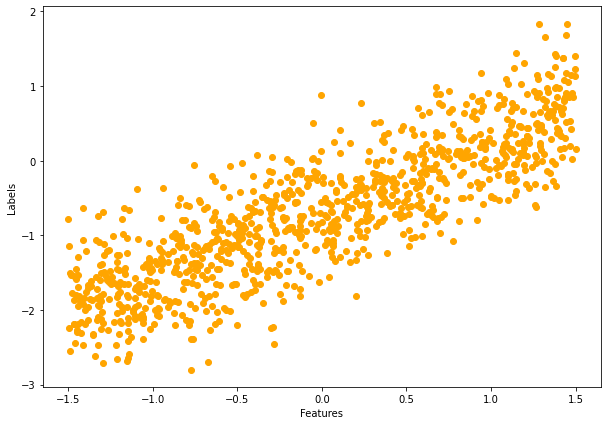

In [5]:
plt.figure(figsize=(10, 7))
plt.scatter(X, y, color="orange")
plt.xlabel("Features")
plt.ylabel("Labels")
plt.plot()

In [6]:
from scipy.stats import multivariate_normal
from scipy.stats import norm as univariate_normal


class BayesianLinearRegression:
    def __init__(
        self, prior_mean: np.ndarray, prior_cov: np.ndarray, noise_var: float
    ) -> None:
        self.prior_mean = prior_mean[:, None]  # Column vector (d, 1)
        self.prior_cov = prior_cov  # Matrix of shape (d, d)
        self.prior = multivariate_normal(prior_mean, prior_cov)

        self.noise_var = noise_var
        self.noise_precision = 1 / noise_var  # Reciprocal of variance

        self.param_posterior = self.prior
        self.post_mean = self.prior_mean
        self.post_cov = self.prior_cov

    def update_posterior(self, features: np.ndarray, targets: np.ndarray) -> None:

        targets = targets[:, None]  # Column vector (N, 1)
        full_feature_matrix = self.add_bias(features)

        matrix_dot_product = full_feature_matrix.T.dot(full_feature_matrix)
        inv_prior_cov = np.linalg.inv(self.prior_cov)
        self.post_cov = np.linalg.inv(
            inv_prior_cov + self.noise_precision * matrix_dot_product
        )

        # Update the mean, shape (2, 1)
        self.post_mean = self.post_cov.dot(
            inv_prior_cov.dot(self.prior_mean)
            + self.noise_precision * full_feature_matrix.T.dot(targets)
        )

        # Update the posterior distribution
        self.param_posterior = multivariate_normal(
            self.post_mean.flatten(), self.post_cov
        )

    def add_bias(self, features: np.ndarray) -> np.ndarray:
        phi_0 = np.ones(len(features))
        full_feature_matrix = np.stack((phi_0, features), axis=1)
        return full_feature_matrix

    def predict(self, features: np.ndarray) -> np.ndarray:

        full_feature_matrix = self.add_bias(features)

        pred_mean = full_feature_matrix.dot(self.post_mean)
        pred_cov = (
            full_feature_matrix.dot(self.post_cov.dot(full_feature_matrix.T))
            + self.noise_var
        )

        pred_posterior = univariate_normal(loc=pred_mean.flatten(), scale=pred_cov)
        return pred_posterior

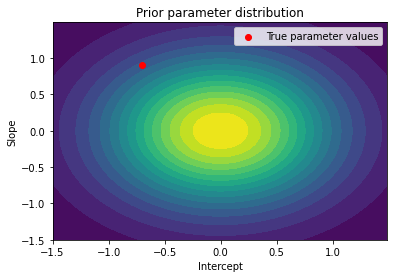

In [8]:
prior_mean = np.array([0, 0])
prior_cov = 1 / 2 * np.identity(2)
model = BayesianLinearRegression(prior_mean, prior_cov, noise_var)


def plot_param_posterior(lower_bound, upper_bound, model, title):
    fig = plt.figure()
    mesh_features, mesh_labels = np.mgrid[
        lower_bound:upper_bound:0.01, lower_bound:upper_bound:0.01
    ]
    pos = np.dstack((mesh_features, mesh_labels))
    plt.contourf(mesh_features, mesh_labels, model.param_posterior.pdf(pos), levels=15)
    plt.scatter(intercept, slope, color="red", label="True parameter values")
    plt.title(title)
    plt.xlabel("Intercept")
    plt.ylabel("Slope")
    plt.legend()

plot_param_posterior(
    lower_bound, upper_bound, model, title="Prior parameter distribution"
)

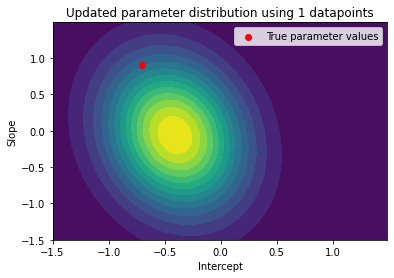

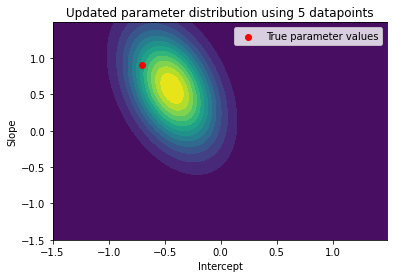

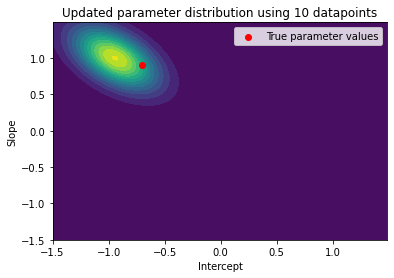

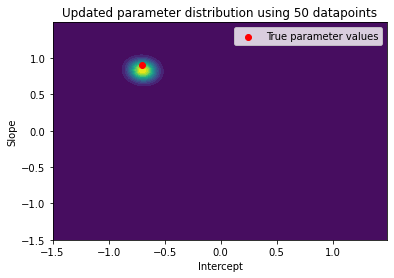

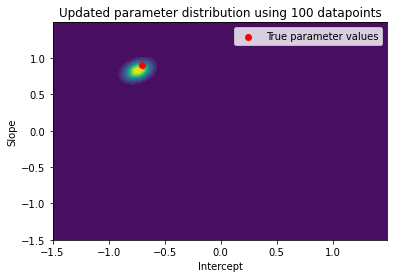

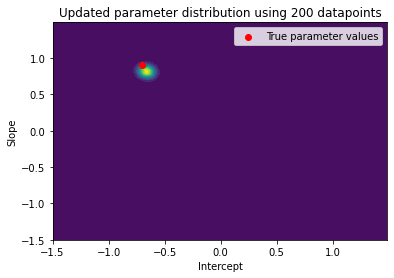

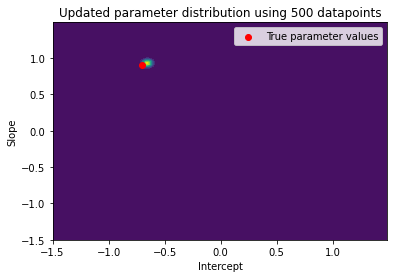

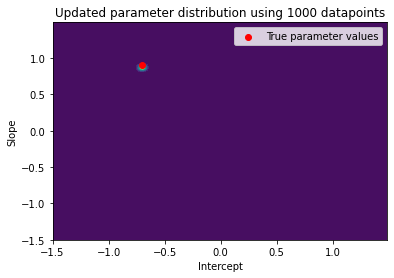

In [11]:
import pandas as pd
import seaborn as sns

n_points_lst = [1, 5, 10, 50, 100, 200, 500, 1000]
previous_n_points = 0

for n_points in n_points_lst:
    train_features = X[previous_n_points:n_points]
    train_labels = y[previous_n_points:n_points]
    model.update_posterior(train_features, train_labels)

    # Visualize updated parameter posterior distribution
    plot_param_posterior(
        lower_bound,
        upper_bound,
        model,
        title=f"Updated parameter distribution using {n_points} datapoints",
    )

    previous_n_points = n_points

def linear_func(
    slope: float,
    intercept: float,
    data: np.ndarray,
) -> np.ndarray:

    return slope * data + intercept


[]

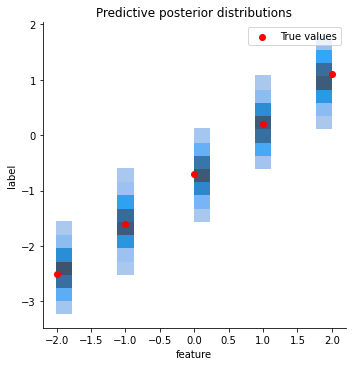

In [12]:
all_rows = []
sample_size = 1000
test_features = [-2, -1, 0, 1, 2]
all_labels = []

for feat in test_features:
    true_label = linear_func(slope, intercept, np.array([feat]))
    all_labels.append(true_label)
    pred_posterior = model.predict(np.array([feat]))
    sample_predicted_labels = pred_posterior.rvs(size=sample_size)
    for label in sample_predicted_labels:
        all_rows.append([feat, label])

all_data = pd.DataFrame(all_rows, columns=["feature", "label"])
sns.displot(data=all_data, x="feature", y="label")
plt.scatter(x=test_features, y=all_labels, color="red", label="True values")
plt.title("Predictive posterior distributions")
plt.legend()
plt.plot()